In [ ]:
import numpy as np
from pyscf import ao2mo, gto, mcscf, scf
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.circuit.library.initial_states.hartree_fock import HartreeFock
from qiskit_algorithms.time_evolvers.time_evolution_problem import TimeEvolutionProblem 
from qiskit_algorithms.time_evolvers.classical_methods import SciPyImaginaryEvolver
from pyscf_molecule import Molecule
from utils import make_geometry
from qiskit_nature.second_q.mappers import JordanWignerMapper



In [22]:
## Mol object
molecule = 'H2'
geometry = make_geometry(molecule)
basis_set =  'ccpvdz'
charge = 0
spin = 0
mol = Molecule(geometry, run_fci=False, basis=basis_set, unit='Bohr', charge=charge, spin=spin)
mol = mol.mol
mf = scf.RHF(mol)
mf.scf()
 
print(
    mf.energy_nuc(),
    mf.energy_elec()[0],
    mf.energy_tot(),
    mf.energy_tot() - mol.energy_nuc(),
)

active_space = range(mol.nelectron // 2 - 1, mol.nelectron // 2 + 1)

E1 = mf.kernel()
mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1))
mo = mx.sort_mo(active_space, base=0)
E2 = mx.kernel(mo)[:2]

h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)



Running restricted UHF (!)... (might want RHF)
converged SCF energy = -1.12871101060159
converged SCF energy = -1.12871101060159
-1.1287110106015903
UHF done.
converged SCF energy = -1.12871101060159
0.7141393157259904 -1.8428503263275817 -1.1287110106015912 -1.8428503263275817
converged SCF energy = -1.12871101060159
CASCI E = -1.13145068427839  E(CI) = -1.84559000000438  S^2 = 0.0000000


In [23]:
def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng

def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])
 
 
def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                ell, r = "I" * (n - 1), ""
            elif p == n - 1:
                ell, r = "", "Z" * (n - 1)
            else:
                ell, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(ell + "X" + r, 0.5), (ell + "Y" + r, 0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list

def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape
 
    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)
 
    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)
 
    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg
 
    return H.chop().simplify()

In [24]:
ham = build_hamiltonian(ecore, h1e, h2e)
print(ham)

accuracy of Cholesky decomposition  2.7755575615628914e-16
SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IIZI', 'ZIII', 'IZIZ', 'IIZZ', 'ZIIZ', 'IZZI', 'ZZII', 'ZIZI', 'YYYY', 'XXYY', 'YYXX', 'XXXX'],
              coeffs=[-0.44756101+0.j, -0.28244902+0.j, -0.28244902+0.j,  0.00402246+0.j,
  0.00402246+0.j,  0.16465817+0.j,  0.08211967+0.j,  0.09614389+0.j,
  0.09614389+0.j,  0.08211967+0.j,  0.08366192+0.j,  0.01402422+0.j,
  0.01402422+0.j,  0.01402422+0.j,  0.01402422+0.j])


In [34]:
tau = 10.0
dtau = 0.0001
nsteps = int(tau // dtau) + 1
probe = 50


num_spatial_orbitals = len(list(active_space))
num_elec = num_spatial_orbitals
mapper = JordanWignerMapper()


initial_state = HartreeFock(num_spatial_orbitals, (num_elec//2, num_elec//2),mapper)

evol_pb = TimeEvolutionProblem(ham, tau, initial_state, aux_operators=[ham])

imag_evolver = SciPyImaginaryEvolver(num_timesteps=nsteps)





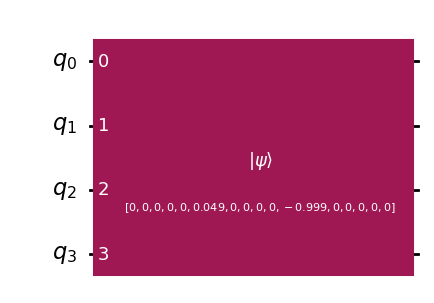

In [35]:
result = imag_evolver.evolve(evol_pb)

result_circ = QuantumCircuit(2*mol.nelectron)
result_circ.initialize(result.evolved_state)
result_circ.draw('mpl')

In [36]:
energies = result.observables[0][0][::probe]
print(energies)


[ 0.01717489+0.j  0.01714324+0.j  0.01711123+0.j ... -1.13145063+0.j
 -1.13145064+0.j -1.13145064+0.j]


In [37]:
fout = open(f'QITE_{molecule}.out','w')
fout.write("QITE simulation \n")
for i, E in enumerate(energies):
    fout.write("%.0f %.6f %.6f \n" % (i*probe, i*probe*dtau, E))



/var/folders/2n/wp73tnrd0qdg0nmgbbs100bw0000gn/T/ipykernel_861/933945257.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  fout.write("%.0f %.6f %.6f \n" % (i*probe, i*probe*dtau, E))


In [9]:
from qiskit.primitives import StatevectorEstimator

estimator_perfect = StatevectorEstimator()
qc = (result_circ, ham)
result_perfect = estimator_perfect.run([qc]).result()
print(result_perfect[0].data.evs)

-0.006911566150977906


In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend)

management.get:WARNING:2025-11-11 15:15:53,451: Loading default saved account
qiskit_runtime_service.__init__:WARNING:2025-11-11 15:16:02,022: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-11 15:16:02,370: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-11 15:16:04,687: Using instance: open-instance, plan: open


<IBMBackend('ibm_torino')>


In [11]:
backend.configuration().basis_gates

['cz', 'id', 'rz', 'sx', 'x']

In [12]:
from qiskit.compiler import transpile

result_circ_qpu= result_circ

isa_result_circ_qpu = transpile(result_circ_qpu, backend) #I transpile only one beacause otherwise it'll takes hours

Depth of circuit : 58


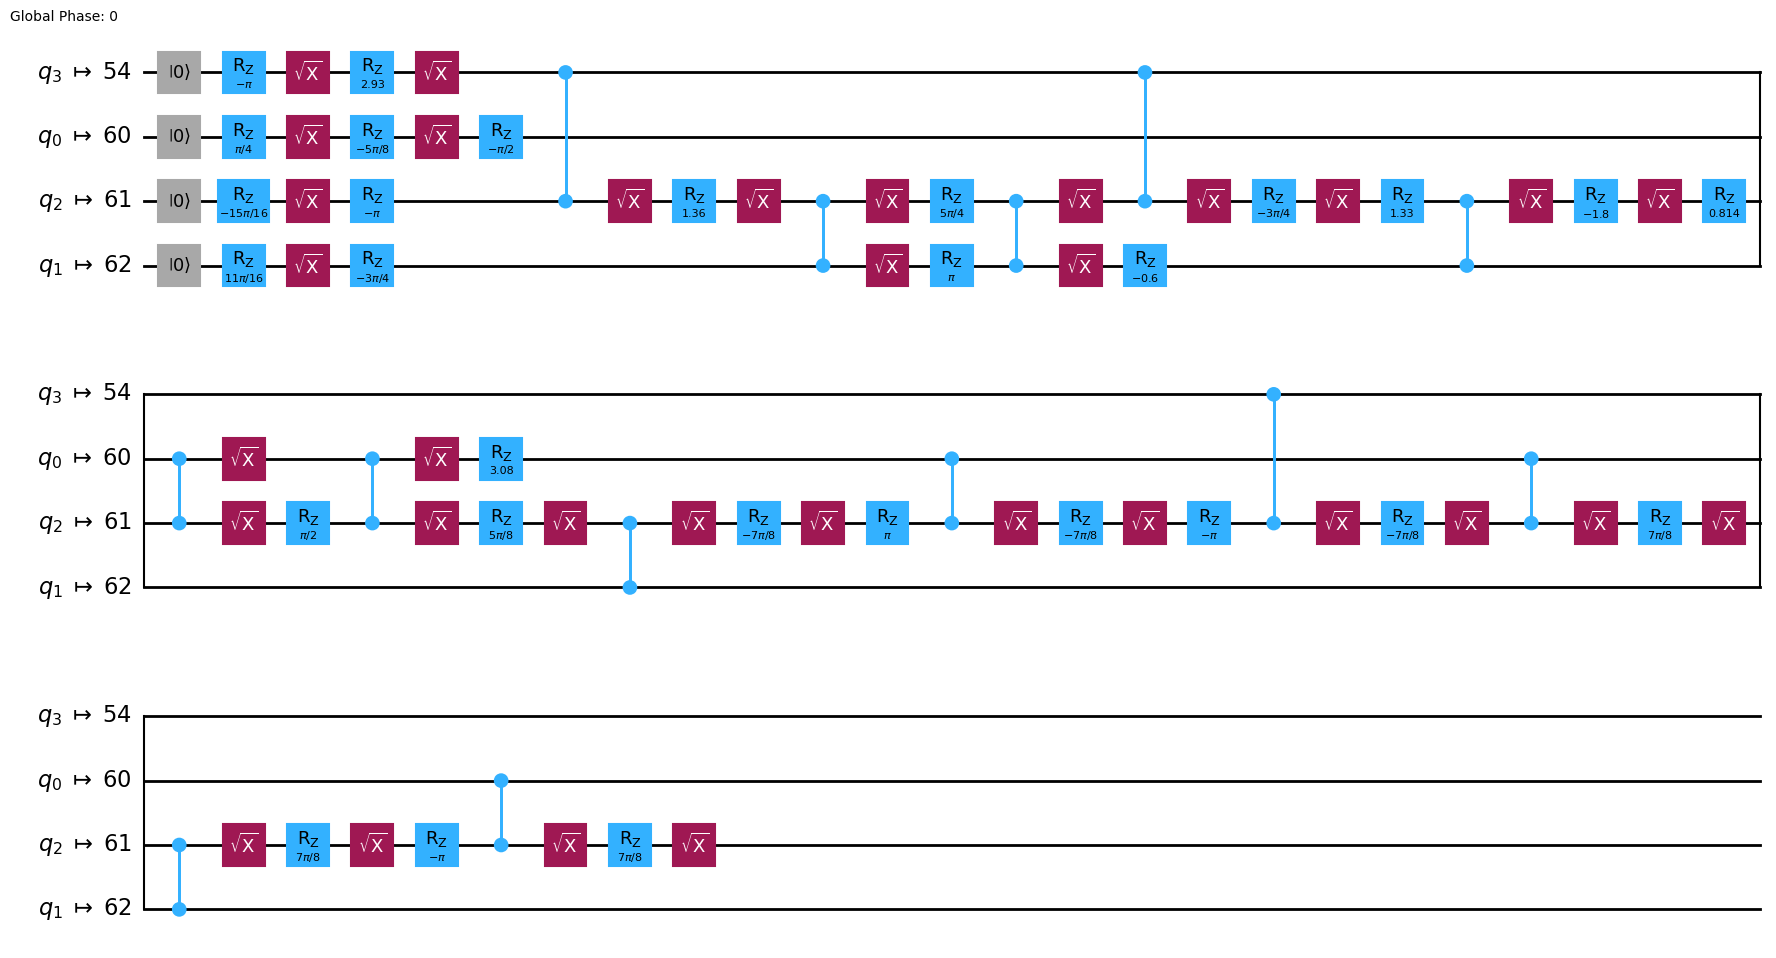

In [13]:
i_example = 0
isa_qc_example = isa_result_circ_qpu
print(f'Depth of circuit : {isa_qc_example.depth()}')
isa_qc_example.draw('mpl', idle_wires=False)

In [14]:
isa_ham = ham.apply_layout(isa_qc_example.layout)

In [15]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator_true = Estimator(mode=backend)

In [16]:
job = estimator_true.run([(isa_result_circ_qpu,isa_ham)], precision=0.01)

In [17]:
job = service.job('d43o6787i53s73e4bc4g')
job_result = job.result()

In [18]:
for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: -1.1075440371579328


In [19]:
job = service.job('d43p5uh0f7bc7388m8d0')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: -1.0956204467115185


In [20]:
job = service.job('d43pbto7i53s73e4cgkg')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: -1.105613862067647
